In [1]:
from numpy import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pprint import pprint

 v_ef = freq * 7.216969696969696e-05 + -0.00033333333333335544
 mu0 = 1.2566370614359173e-06
 mu = 1.1958712384959098e-06


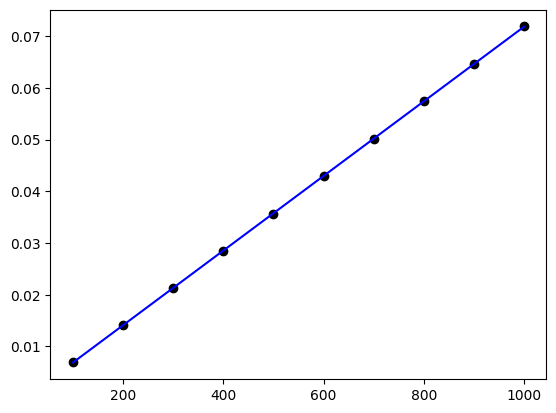

In [2]:
D = 41 # mm de diámetro
r = D / 2 # radio
A = pi * (r/1000)**2 # área de la sección en m**2
n = 300 # número de vueltas de la espira
N = 485 # N/L = 485 vueltas/m
I_ef = 50 / 1000 # A (mA/1000)

freq = array([ 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ]) # frecuencias comprendidas entre 100 Hz y 1KHz
v_ef = array([ 7, 14.1, 21.3, 28.5, 35.7, 42.9, 50.1, 57.4, 64.7, 71.9 ]) / 1000 # A (mA/1000)

b, a = polyfit(freq, v_ef, 1)
print(f" v_ef = freq * {b} + {a}")

mu0 = 4e-7 * pi
print(f" mu0 = {mu0}")

mu = b / (2 * pi * A * n * N * I_ef)
print(f" mu = {mu}")

f = plt.figure()
plt.plot(freq, v_ef, 'ko')
plt.plot( [ freq[0], freq[-1] ], [ a+b*freq[0], a+b*freq[-1] ], 'b-')


In [3]:
from scipy import stats
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html

freq = array([ 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ]) # frecuencias comprendidas entre 100 Hz y 1KHz
v_ef = array([ 7, 14.1, 21.3, 28.5, 35.7, 42.9, 50.1, 57.4, 64.7, 71.9 ]) / 1000 # A (mA/1000)

slope, intercept, r_value, p_value, std_err = stats.linregress(freq, v_ef)
print(f"slope={slope}, intercept={intercept}, r_value={r_value}, p_value={p_value}, std_err={std_err}")

err = 1 / (2 * pi * A * n * N * I_ef) * (std_err + slope / I_ef * 0.0001)
print(f"error={err}")

slope=7.216969696969698e-05, intercept=-0.00033333333333333826, r_value=0.999995317396591, p_value=2.1034157662111526e-21, std_err=7.808544682836994e-08
error=3.6856392775611554e-09


 v_ef = A * 55.74108069613493 + -0.0006874118420072849
 mu0 = 1.2566370614359173e-06
 mu = 1.2194458455084672e-06


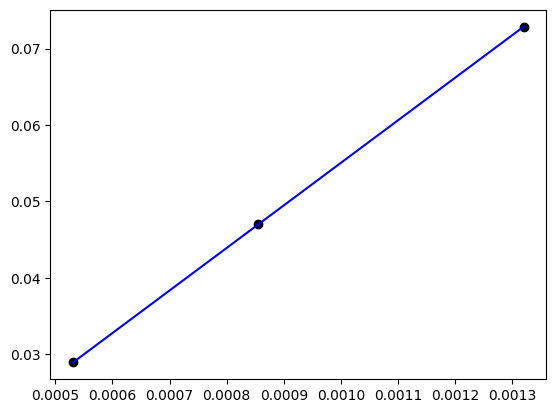

In [4]:
D = array([ 26, 33, 41 ]) # mm de diámetro
r = D / 2 # radio
A = pi * (r/1000)**2 # área de la sección en m**2
n = 300 # número de vueltas de la espira
freq = 1000 # Hz
v_ef = array([ 28.9, 47, 72.9 ]) / 1000 # A (mA/1000)

b, a = polyfit(A, v_ef, 1)
print(f" v_ef = A * {b} + {a}")

mu0 = 4e-7 * pi
print(f" mu0 = {mu0}")

mu = b / (2 * pi * freq * n * N * I_ef)
print(f" mu = {mu}")

f = plt.figure()
plt.plot(A, v_ef, 'ko')
plt.plot( [ A[0], A[-1] ], [ a+b*A[0], a+b*A[-1] ], 'b-')


In [5]:
from scipy import stats
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html

slope, intercept, r_value, p_value, std_err = stats.linregress(A, v_ef)
print(f"slope={slope}, intercept={intercept}, r_value={r_value}, p_value={p_value}, std_err={std_err}")

slope=55.74108069613493, intercept=-0.0006874118420072961, r_value=0.9999998857330004, p_value=0.00030433754780227426, std_err=0.026647153980924335


 v_ef = n * 0.0002444999999999999 + -0.0003666666666666325
 mu0 = 1.2566370614359173e-06
 mu = 1.2154291763273742e-06


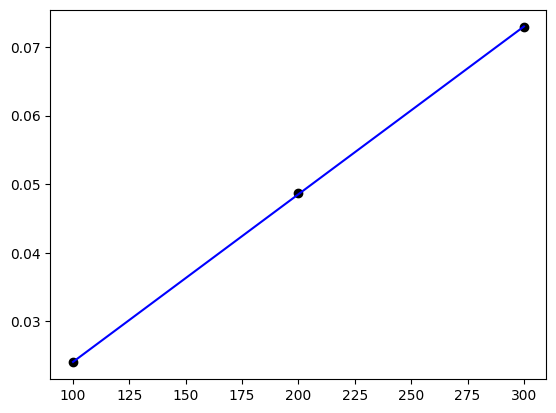

In [6]:
D = 41 # mm de diámetro
r = D / 2 # radio
A = pi * (r/1000)**2 # área de la sección en m**2
n = array([ 100, 200, 300 ]) # número de vueltas de la espira
freq = 1000 # Hz
v_ef = array([ 24, 48.7, 72.9 ]) / 1000 # A (mA/1000)

b, a = polyfit(n, v_ef, 1)
print(f" v_ef = n * {b} + {a}")

mu0 = 4e-7 * pi
print(f" mu0 = {mu0}")

mu = b / (2 * pi * A * N * I_ef * freq)
print(f" mu = {mu}")

f = plt.figure()
plt.plot(n, v_ef, 'ko')
plt.plot( [ n[0], n[-1] ], [ a+b*n[0], a+b*n[-1] ], 'b-')


In [7]:
from scipy import stats
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html

slope, intercept, r_value, p_value, std_err = stats.linregress(n, v_ef)
print(f"slope={slope}, intercept={intercept}, r_value={r_value}, p_value={p_value}, std_err={std_err}")

slope=0.00024450000000000003, intercept=-0.0003666666666666679, r_value=0.9999825755255122, p_value=0.0037581628560091574, std_err=1.443375672970692e-06
